# Lab 3: Gaussian process regression

### Machine Learning 1, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is October 30th (Sunday) 23:59 after the final exam.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: Make sure we can run your notebook / scripts!
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bxp}{\mathbf{x}^{'}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\xm}{\mathbf{x}_m}$
$\newcommand{\xn}{\mathbf{x}_n}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\yi}{\y_i}$
$\newcommand{\thetav}{\mathbf{\theta}}$
$\newcommand{\t}{\mathbf{t}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\tN}{\mathbf{t}_N}$
$\newcommand{\xN}{\mathbf{x}_N}$
$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\CN}{\mathbf{C}_N}$
$\newcommand{\KN}{\mathbf{K}_N}$
$\newcommand{\eyeN}{\mathbf{I}_N}$

# Gaussian process regression

For this Lab we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at http://www.automaticstatistician.com/index.php by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.




### Sinusoidal Data

We will use the same data generating function that we used previously for regression.  You can change sigma/beta, but keep it reasonable.  Definitely play around once you have things working.  Make use of these functions as you wish.

In [1]:
%pylab inline
%matplotlib inline
import pylab as pp
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
sigma = 0.5
beta  = 1.0 / pow(sigma,2) # this is the beta used in Bishop Eqn. 6.59
N_test = 100
x_test = np.linspace(-1,1,N_test)
mu_test = np.zeros( N_test )

In [3]:
def true_mean_function( x ):
    return np.sin( 2*pi*(x+1) )

def add_noise( y, sigma ):
    return y + sigma*np.random.randn(len(y))

def generate_t( x, sigma ):
    return add_noise( true_mean_function( x), sigma )

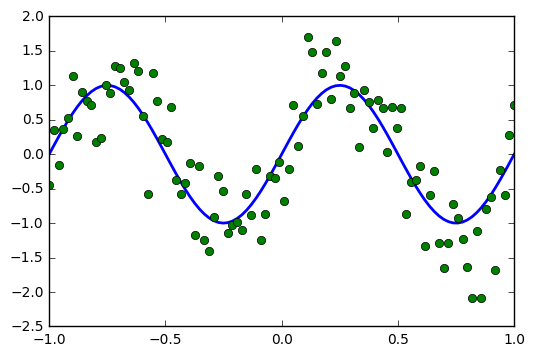

In [4]:
y_test = true_mean_function( x_test )
t_test = add_noise( y_test, sigma )
pp.plot( x_test, y_test, 'b-', lw=2)
pp.plot( x_test, t_test, 'go')
show()

### 1. Sampling from the Gaussian process prior (30 points)

We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 k_n_m( xn, xm, thetas ) (10 points)
To start, implement function "k_n_m( xn, xm, thetas )" that takes scalars $\xn$ and $\xm$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points). 

In [5]:
def k_n_m(xn, xm, thetas):
    return thetas[0] * np.exp(-(thetas[1] / 2.0) * (xn - xm) ** 2) + thetas[2] + thetas[3] * xn * xm

#### 1.2 computeK( X1, X2, thetas ) (5 points)
Eqn 6.60 is the marginal distribution of mean ouput of $N$ data vectors: $p(\y) = \mathcal{N}(\zero, \K)$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N$ by $N$ kernel matrix $\K$.  Write a function "computeK( X1, X2, thetas )" that computes the kernel matrix. Hint: use k_n_m as part of an innner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary) (5 points).  

In [6]:
def computeK(X1, X2, thetas):
    N = len(X1)
    M = len(X2)
    K = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            K[i,j] = k_n_m(X1[i], X2[j], thetas)
    return K

# thetas = [1,4,0,1]
# x_test = x_test.reshape((len(x_test),1))
# K = computeK(x_test, x_test, thetas)

#### 1.3 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\yi \sim \mathcal{N}(\zero, \K_{\thetav})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\y$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\K$ (the diagonal of $\K$ is the variance of the model uncertainty) (15 points).

/home/dana/.local/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: covariance is not positive-semidefinite.


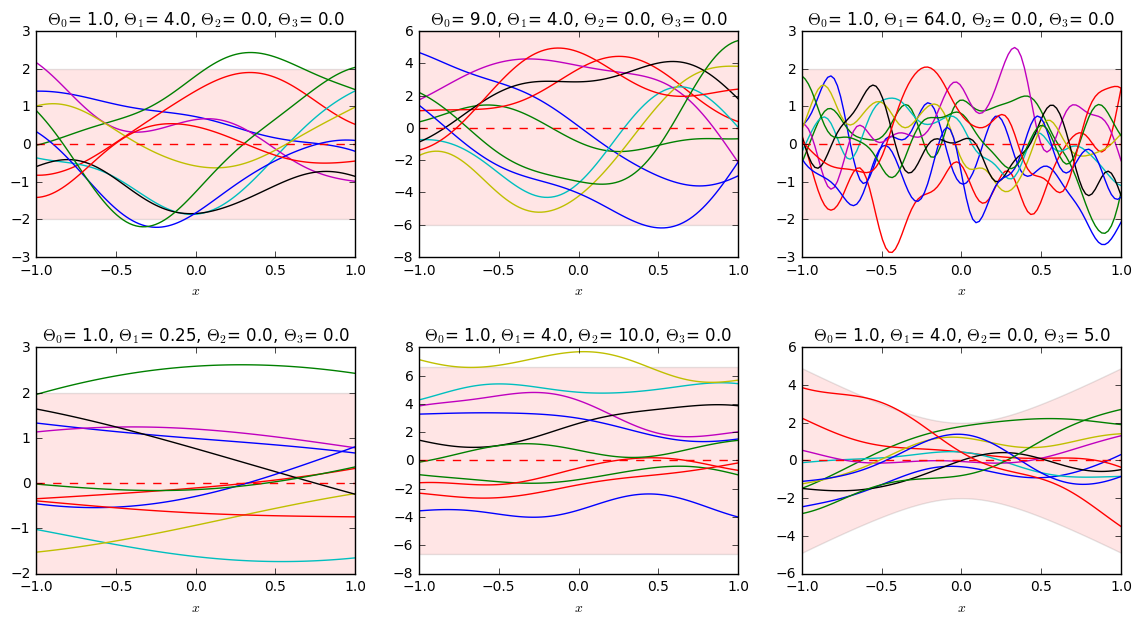

In [7]:
thetaM = np.array([[1,4,0,0],[9,4,0,0],[1,64,0,0],[1,0.25,0,0],[1,4,10,0],[1,4,0,5]])

N = len(x_test)

figure(num=None, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')

subplots_adjust(hspace = 0.4)

for i in range(len(thetaM)):
    
    K = computeK(x_test, x_test, thetaM[i])

    pred_std = reshape(sqrt(diag(K)), (N, -1))
    y_mean = np.zeros((N,1))
    mms = [item for sublist in y_mean - 2 * pred_std for item in sublist]
    mps = [item for sublist in y_mean + 2 * pred_std for item in sublist]

    subplot(2, 3, i+1)
    
    for s in range(10):
        w = numpy.random.multivariate_normal(zeros(len(x_test)),K)
        plt.plot(x_test,w)
    
    plt.plot(x_test, y_mean, 'r--')
    fill_between(x_test, mms, mps, facecolor='red', alpha=0.1)
         
    xlabel('$x$')
    title('$\Theta_0$= '+str(thetaM[i,0]) + ', $\Theta_1$= '+str(thetaM[i,1]) + ', $\Theta_2$= '+str(thetaM[i,2]) + ', $\Theta_3$= '+str(thetaM[i,3]))

show()

### 2. Predictive distribution (35 points)

So far we have sampled mean functions from the prior.  We can draw actual data $\t$ two ways.  The first way is generatively, by first sampling $\y | \K$, then sampling $\t | \y, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\y$ (the mean draw) and directly sample $\t | \K, \beta$ using Eqn 6.61.    This is the generative process for $\t$.  Note that we have not specified a distribution over inputs $\x$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\x$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $\CN$, $\k$, and $c$.  The covariance matrix $\CN$ for $\tN$ is $\CN = \KN + \eyeN / \beta$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\k$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function "gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C = None)" that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data.  By having C as an optional parameter, we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\C$, $\k$ and $c$, and return the mean and noise functions.  Do not forget: the computeK function computes $\K$, not $\C$! (10 points)

In [33]:
def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C = None, invC = None):
    N = len(x_train)
    T = len(x_test)
    
    noise = zeros((T,1))
    
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + (1 / beta) * np.identity(N)
    
    if invC is None:
        invC = inv(C)
    
    K_tilde = computeK(x_train, x_test, theta)
    
    m = dot(K_tilde.T, dot(invC,reshape(t_train,(N,-1))))
    
    for i in range(T):
        x = x_test[i]
        c = k_n_m(x,x,theta) + (1 / beta)
        noise[i] = c - dot(K_tilde[:,i].T, dot(invC, K_tilde[:,i]))
    
    return m, noise


# mean_pred, var_pred  = gp_predictive_distribution(x_test, t_test, np.asarray([1]), [1,4,0,0], beta)

# # Should be close to 1
# print mean_pred, var_pred
# print beta

#### 2.2 gp_log_likelihood(...) (10 points)
Later, to learn the hyperparameters, we will need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\thetav$.  Write a function "gp_log_likelihood( x_train, t_train, theta, C = None, invC = None, beta = None)", where C and invC can be stored and reused.  (10 points) Note: you need to add beta if you want to calculate C.

In [34]:
def gp_log_likelihood( x_train, t_train, theta, C = None, invC = None, beta = None):
    
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + (1 / beta) * np.identity(N)
    
    if invC is None:
        invC = inv(C)
        
    N = len(t_train)
    t = reshape(t_train,(N,-1))
    return -1/2.0 * (log(det(C)) + dot(t.T, dot(invC, t)) + N * log(2*pi))

#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the sinuosoidal data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. (10 points)  Try to understand the two types of uncertainty!  If you do not use "gp_plot", please add a fill between for the model and target noise. 

In [35]:
def gp_plot( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta ):
    # x_test:   the test data
    # y_test:   the true function at x_test
    # mu_test:  predictive mean at x_test
    # var_test: predictive covariance at x_test 
    # t_train:  the training values
    # theta:    the kernel parameters
    # beta:     the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(np.diag(var_test))         # includes all uncertainty, model and target noise 
    std_model = np.sqrt( std_total**2 - 1.0/beta ) # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt( 1.0/beta )    # add stddev (note: not the same as full)
    
    pp.plot( x_test, y_test, 'b', lw=3)
    pp.plot( x_test, mu_test, 'k--', lw=2 )
    
    mpc = [item[0] for item in mu_test+2*std_combo]
    mmc = [item[0] for item in mu_test-2*std_combo]
    pp.fill_between( x_test, mpc,mmc, color='k', alpha=0.25 )
    
    mpc = [item[0] for item in mu_test+2*std_model]
    mmc = [item[0] for item in mu_test-2*std_model]
    pp.fill_between( x_test, mpc, mmc, color='r', alpha=0.25 )
    
    pp.plot( x_train, t_train, 'ro', ms=10 )

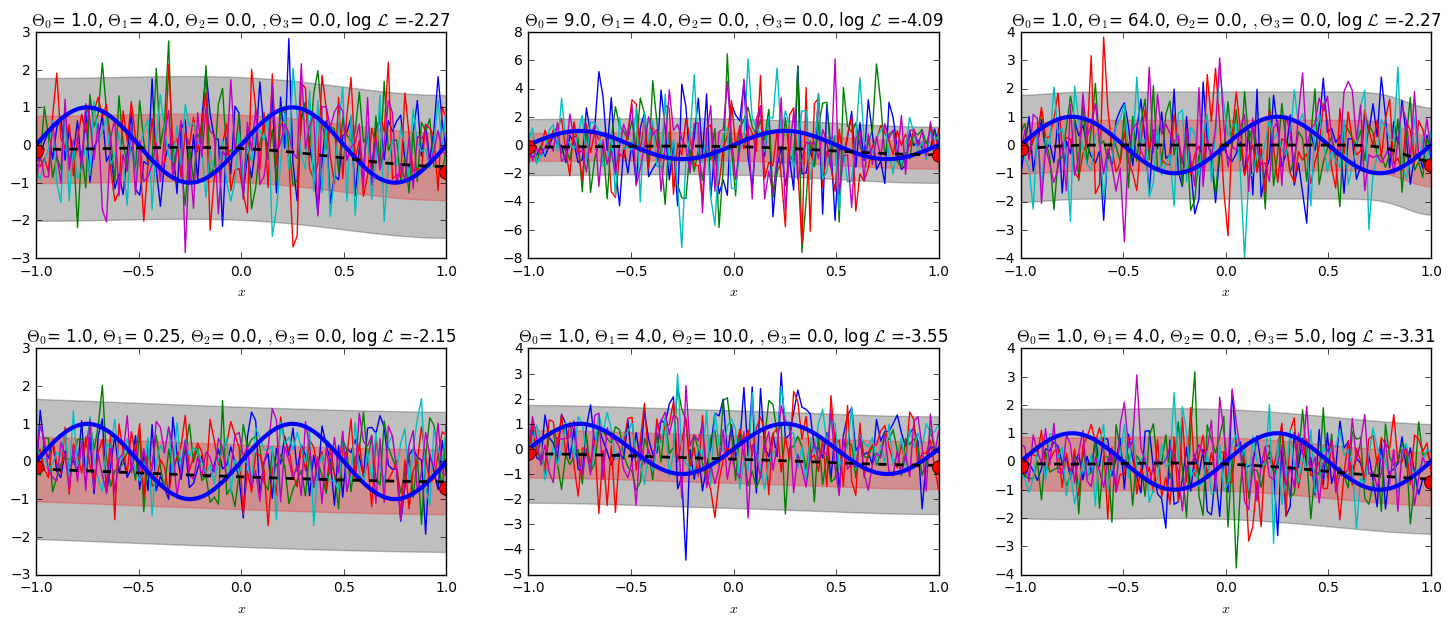

(100,)


In [37]:
x_train = np.linspace(-1,1,2)
t_train = add_noise( true_mean_function( x_train ), sigma )
N = len(x_train)

thetaM = np.array([[1,4,0,0],[9,4,0,0],[1,64,0,0],[1,0.25,0,0],[1,4,10,0],[1,4,0,5]])

figure(num=None, figsize=(18, 7), dpi=80, facecolor='w', edgecolor='k')
subplots_adjust(hspace = 0.4)

for i in range(len(thetaM)):
    
    theta = thetaM[i]
    
    K = computeK(x_train, x_train, theta)
    C = K + (1 / beta) * np.identity(N)
    invC = inv(C)
    
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C, invC)
    
    subplot(2, 3, i+1)
    
    for s in range(5):
        w = numpy.random.multivariate_normal(zeros(len(x_test)),diag(var_test[:,0]))
        plt.plot(x_test,w)
    
    gp_plot( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta )
    
    log_like = gp_log_likelihood( x_train, t_train, theta, C, invC, beta)
    log_like = round(log_like[0,0],2)
    
    xlabel('$x$')
    
    title('$\Theta_0$= '+str(theta[0]) + ', $\Theta_1$= '+str(theta[1]) + ', $\Theta_2$= '+str(theta[2]) + ', $, \Theta_3$= '+str(theta[3]) + ', log $\mathcal{L}$ =' + str(log_like))

show()
print x_test.shape

#### 2.4 More ploting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

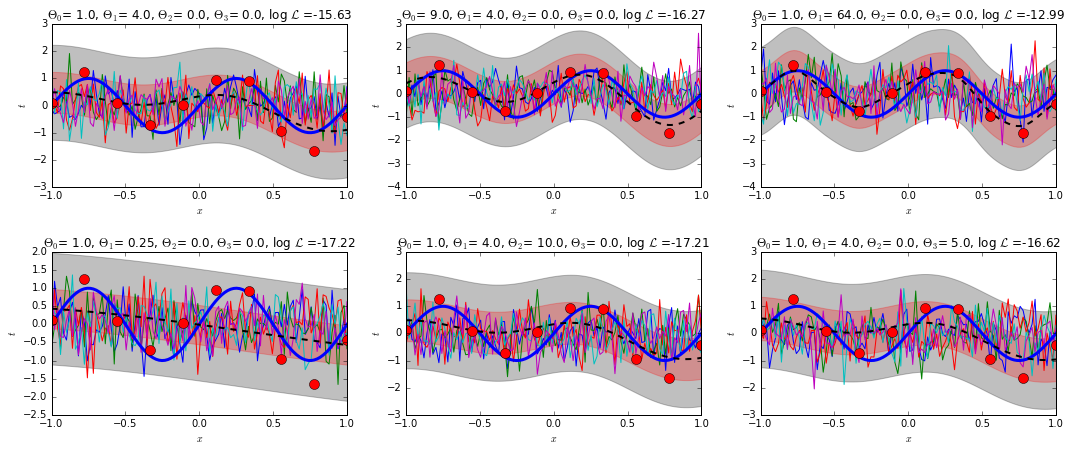

In [93]:
x_train = np.linspace(-1,1,10); 
t_train = add_noise( true_mean_function( x_train ), sigma )

xa_train = x_train; 
ta_train = t_train

N = len(x_train)

thetaM = np.array([[1,4,0,0],[9,4,0,0],[1,64,0,0],[1,0.25,0,0],[1,4,10,0],[1,4,0,5]])

figure(num=None, figsize=(18, 7), dpi=80, facecolor='w', edgecolor='k')
subplots_adjust(hspace = 0.4)

for i in range(len(thetaM)):
    
    theta = thetaM[i]
    
    K = computeK(x_train, x_train, theta)
    C = K + (1 / beta) * np.identity(N)
    invC = inv(C)
    
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C, invC)
    
    subplot(2, 3, i+1)
    
    for s in range(5):
        w = numpy.random.multivariate_normal(zeros(len(x_test)),diag(var_test[:,0]))
        plt.plot(x_test,w)
    
    gp_plot( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta )
    
    log_like = gp_log_likelihood( x_train, t_train, theta, C, invC, beta)
    log_like = round(log_like[0,0],2)
    
    xlabel('$x$')
    ylabel('$t$')
    
    title('$\Theta_0$= '+str(theta[0]) + ', $\Theta_1$= '+str(theta[1]) + ', $\Theta_2$= '+str(theta[2]) + ', $\Theta_3$= '+str(theta[3]) + ', log $\mathcal{L}$ =' + str(log_like))

show()

### 3. Learning the hyperparameters (45 points)

Learning the values of the parameter $\thetav$ can be very tricky for Gaussian processes in general, but when the data is univariate like ours, we can visualize the fit and see how plausible it looks.

#### 3.1 Derivatives (5 points)
Maximum likelihood or MAP learning is the most common way of setting the parameters, though a fully Bayesian approach is possible too.  We will look at ML today.  For this, we start with the dervivative of the log-likelihood with respect to the parameters $\thetav$; this is Eqn 6.70.  This, in turn, requires the derivative of the kernel matrix $\CN$ wrt $\thetav$.  This is the matrix of element-wise derivatives of the kernel function.  Write the derivatives for $\theta_0$ to $\theta_3$ for our kernel function (5 points).  

$$k(\bx_n, \bx_m) = \theta_0 \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right) + \theta_2 + \theta_3 \bx_n^T \bx_m$$

Recall that the $(n,m)$ entry of $\CN$ is $C(\bx_n, \bx_m) = k(\bx_n, \bx_m) + \beta^{-1} \delta_{nm}$ for $n$, $m = 1, ..., N$. Therefore, $\CN = \K + \beta^{-1} \eyeN$. This implies that:

$$\frac{\partial \CN}{\partial \theta_l} = \frac{\partial \K}{\partial \theta_l} + \frac{\partial \beta^{-1} \eyeN}{\partial \theta_l} = \frac{\partial \K}{\partial \theta_l}$$

$$\frac{\partial {\CN}_{nm}}{\partial \theta_0} = \frac{\partial \K_{nm}}{\partial \theta_0} = \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right)$$

$$\frac{\partial {\CN}_{nm}}{\partial \theta_1} = \frac{\partial \K_{nm}}{\partial \theta_1} = -\theta_0 \frac{|| \bx_n - \bx_m||^2}{2} \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right)$$

$$\frac{\partial {\CN}_{nm}}{\partial \theta_2} = \frac{\partial \K_{nm}}{\partial \theta_2} = 1$$

$$\frac{\partial {\CN}_{nm}}{\partial \theta_3} = \frac{\partial \K_{nm}}{\partial \theta_3} = \bx_n^T \bx_m$$


#### 3.2 Questions (5 points)
Which parameters in $\thetav$ are constrained, that is, where not all positive/ negative values are valid? (5 points)

According to Bishop's rules for constructing valid kernels and his discussion on the RBF kernel:
  * $\theta_0 > 0$
  * $\theta_1 > 0$
  * $\theta_2$ represents an offset that will not change the shape of the kernel, therefore it is not generally constrained. However it could influde in the (semi) positive definiteness
  * $\theta_3 > 0$
  

#### 3.3 More derivatives (5 points)
For parameters that are constrained to be positive, the usual approach is to use the exponential of the free-parameter in the kernel function, but perform gradient ascent on the unconstrained values.  Consider the case  $\theta_i = \exp( \phi_i)$, where $\phi_i$ is unconstrained.  Write the derivative for $\phi_i$ in terms of the derivatives you already computed (5 points).  Hint: use the chain rule and do not repeat the full derivation.


$$\frac{\partial {\CN}_{nm}}{\partial \phi_0} = \frac{\partial \K_{nm}}{\partial \theta_0} \frac{d \theta_0}{d \phi_0} = \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right) \exp(\phi_0)$$

$$\frac{\partial {\CN}_{nm}}{\partial \phi_1} = \frac{\partial \K_{nm}}{\partial \theta_1} \frac{d \theta_1}{d \phi_1} = -\theta_0 \frac{|| \bx_n - \bx_m||^2}{2} \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right) \exp(\phi_1)$$

$$\frac{\partial {\CN}_{nm}}{\partial \phi_3} = \frac{\partial \K_{nm}}{\partial \theta_3} \frac{d \theta_3}{d \phi_3} = \bx_n^T \bx_m \exp(\phi_3) $$

#### 3.4 Grid search (10 points)
Grid-search: for the same training set you have above, perform a small grid search over $\thetav$ (try at least 20 combinations).  Have your grid-search loop or function print out rows of log-likelihood + $\thetav$ sorted by best to worst.  Use the log-likelihood to select the best $\thetav$ and the worst.  Plots both the same way as the subplots above (ie a 1 by 2 subplot of best and worst). (10 points)

comb.	theta_0	theta_1	theta_2	theta_3	log L
9	1.0	10.0	0.0	0.0	-12.51
10	1.0	10.0	0.0	5.0	-13.584
11	1.0	10.0	10.0	0.0	-14.237
12	1.0	10.0	10.0	5.0	-15.311
21	10.0	10.0	0.0	0.0	-16.318
22	10.0	10.0	0.0	5.0	-16.679
23	10.0	10.0	10.0	0.0	-17.062
5	1.0	1.0	0.0	0.0	-17.187
24	10.0	10.0	10.0	5.0	-17.423
1	1.0	0.1	0.0	0.0	-17.588
6	1.0	1.0	0.0	5.0	-17.897
2	1.0	0.1	0.0	5.0	-17.917
13	10.0	0.1	0.0	0.0	-18.412
7	1.0	1.0	10.0	0.0	-18.543
15	10.0	0.1	10.0	0.0	-18.767
3	1.0	0.1	10.0	0.0	-18.788
4	1.0	0.1	10.0	5.0	-19.116
14	10.0	0.1	0.0	5.0	-19.116
8	1.0	1.0	10.0	5.0	-19.253
16	10.0	0.1	10.0	5.0	-19.47
17	10.0	1.0	0.0	0.0	-19.843
18	10.0	1.0	0.0	5.0	-20.247
19	10.0	1.0	10.0	0.0	-20.346
20	10.0	1.0	10.0	5.0	-20.75


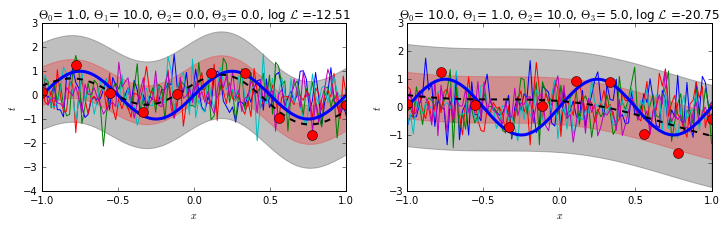

In [94]:
thetaM = np.asarray(list(itertools.product([1,10],[0.1,1,10],[0,10],[0,5])))
print('comb.\ttheta_0\ttheta_1\ttheta_2\ttheta_3\tlog L') 

log_like = zeros((len(thetaM)))

for i in range(len(thetaM)):
    theta = thetaM[i]
    K = computeK(x_train, x_train, theta)
    C = K + (1 / beta) * np.identity(N)
    invC = inv(C)
    llike = gp_log_likelihood( x_train, t_train, theta, C, invC, beta)
    log_like[i] = round(llike[0,0],3)

ix = np.argsort(-log_like)
for i in ix:
    theta = thetaM[i]
    print (str(i+1)+'\t'+ str(theta[0]) + '\t' + str(theta[1]) + '\t' + str(theta[2]) + '\t' +str(theta[3]) + '\t' + str(log_like[i]))

figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
subplots_adjust(hspace = 0.4)

for i in range(2):
    
    theta = thetaM[ix[-i]]
    
    K = computeK(x_train, x_train, theta)
    C = K + (1 / beta) * np.identity(N)
    invC = inv(C)
    
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C, invC)
    
    subplot(1, 2, i+1)
    
    for s in range(5):
        w = numpy.random.multivariate_normal(zeros(len(x_test)),diag(var_test[:,0]))
        plt.plot(x_test,w)
    
    gp_plot( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta )
    
    log_like = gp_log_likelihood( x_train, t_train, theta, C, invC, beta)
    log_like = round(log_like[0,0],2)
    
    xlabel('$x$')
    ylabel('$t$')
    
    title('$\Theta_0$= '+str(theta[0]) + ', $\Theta_1$= '+str(theta[1]) + ', $\Theta_2$= '+str(theta[2]) + ', $\Theta_3$= '+str(theta[3]) + ', log $\mathcal{L}$ =' + str(log_like))

show()

#### 3.5 Questions (10 points)
Selecting kernel functions can be somewhat of an art.  There are charateristics of kernel functions that are useful for some data sets, but not others.  Complicating the matter is the ability to combine kernels with different characteristics (long term trends + seasonal fluctuations).  Describe the charactistics of the kernel function we are using in terms of (signal, scale, offsets, etc). You may want to play around with $\thetav$ and see what each parameter does/affects/etc.  (5 points)  Describe why the best parameters work well for the training data and explain why the bad parameter settings perform poorly (in terms of the first part of the question).  (5 points)

$$k(\bx_n, \bx_m) = \theta_0 \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right) + \theta_2 + \theta_3 \bx_n^T \bx_m$$

  * $\theta_0$: determines the scale.
  * $\theta_1$: when big, forces points to be really close to be accounted as similar, thus allowing for a more precise local (seasonal, wavy) behaviour.
  * $\theta_2$: represents the offset.
  * $\theta_3$: factor of the linear kernel comparison of the data.
  
Description of the good parameter settings:
  * $\theta_0 = 1$: the y data is scaled between -1 and 1, therefore this parameter makes sense as it coincides with the data scale.
  * $\theta_1 = 10$: we would like to obtain a sinusoidal (curve) behaviour in the predictions, thus a fairly high value for this parameter is required.
  * $\theta_2 = 0$: since the mean y is zero, this value makes sense.
  * $\theta_3 = 0$: since the inputs are real numbers, an stationary kernel is more suitable than a linear one.

Description of the bad parameter settings:
  * $\theta_0 = 10$: bad scale value for modelling y between -1 and 1.
  * $\theta_1 = 1$: the low value for this parameters does not allow the prediction to display a sufficiently curved behaviour as the one shown by the training data.
  * $\theta_2 = 10$: bad offset value for modelling data centered around zero.
  * $\theta_3 = 5$: relatively high relevance for the linear kernel using scalar inputs, which may not be the most natural similarity measure in $\mathbb{R}$.


#### 3.6 Bonus: Implementation (20 points)
Implement gradient-ascent (or descent if you wish) using the combination of a) the log-likelihood objective function and b) the gradients you calculated above.  Run on the training data above and show the log-likehood curve as it learns and a plot of the final model.  Feel free to use available software (eg search for "minimize.py" which uses conjugate gradient descent, or something in scipy).  NB: log-likelihood should be monotonically increasing.  You are encouraged to also search and use "checkgrad".  (20 points)

In [14]:
# %load check_grad.py
from numpy import *

def checkgrad(f,g,x,e,RETURNGRADS=False,**kwargs):
    from pylab import norm
    """Check correctness of gradient function g at x by comparing to numerical
       approximation using perturbances of size e. Simple adaptation of 
       Carl Rasmussen's matlab-function checkgrad."""

    dy = g(x,**kwargs)
    if isscalar(x):
        dh = zeros(1,dtype=float)
        l = 1
    else:
        print "x in checkgrad:"
        print x 
        l = len(x)
        dh = zeros(l,dtype=float)
    for j in range(l):
        dx = zeros(l,dtype=float)
        dx[j] = e
        y2 = f(x+dx,**kwargs)
        y1 = f(x-dx,**kwargs)
        #print dx,y2,y1
        dh[j] = (y2 - y1)/(2*e)
        #print dh[j]
    print "analytic (gradient call): \n", dy
    print "approximation (objective call): \n", dh
    if RETURNGRADS: return dy,dh
    else: return norm(dh-dy)/norm(dh+dy)

In [95]:
x_train = xa_train
t_train = ta_train

def gp_loss(theta):
    N = len(t_train)
    
    K = computeK(x_train, x_train, np.array([np.exp(theta[0]), np.exp(theta[1]), theta[2], np.exp(theta[3])]))
    C = K + (1 / beta) * np.identity(N)
    invC = inv(C)
    t = reshape(t_train,(N,-1))
    res = -1/2.0 * (log(max(10**(-8),det(C))) + dot(t.T, dot(invC, t)) + N * log(2*np.pi))
    return -res[0,0]

def grad_thetai(t_train, D, invC):
    t = reshape(t_train,(-1,1))
    aux1 = dot(invC, D)
    return -0.5*np.matrix.trace(aux1) + 0.5*dot(t.T, dot(aux1, dot(invC, t)))

def grad_loss(theta1):
    theta = copy(theta1)
    N = len(x_train)
    
    K = computeK(x_train, x_train, np.array([np.exp(theta[0]), np.exp(theta[1]), theta[2], np.exp(theta[3])]))
    C = K + (1 / beta) * np.identity(N)
    invC = inv(C)
    
    D0 = zeros((N,N))
    D1 = zeros((N,N))
    D2 = zeros((N,N))
    D3 = zeros((N,N))
    
    for n in range(N):
        for m in range(N):
            
            D0[n,m] = np.exp(-np.exp(theta[1]) / 2.0 * (x_train[n] - x_train[m])**2)*np.exp(theta[0])
            D1[n,m] = -np.exp(theta[0]) / 2.0 * ((x_train[n] - x_train[m])**2) * np.exp(-np.exp(theta[1]) / 2.0 * (x_train[n] - x_train[m])**2)*np.exp(theta[1])
            D2[n,m] = 1 
            D3[n,m] = x_train[n] * x_train[m] * np.exp(theta[3])
            
    df0 = grad_thetai(t_train, D0, invC)
    df1 = grad_thetai(t_train, D1, invC)
    df2 = grad_thetai(t_train, D2, invC)
    dt3 = grad_thetai(t_train, D3, invC)
    
    return -np.array([df0[0,0], df1[0,0], df2[0,0], dt3[0,0]])

#### Note that the theoretical (implemented) gradients and their approximation are very close.

In [108]:
theta_0 = np.array([1,1,0,0.5])

print checkgrad(gp_loss,grad_loss,theta_0,0.001,RETURNGRADS=False)

x in checkgrad:
[ 1.   1.   0.   0.5]
analytic (gradient call): 
[ 0.6104077  -2.78472262  0.3916244   0.26494542]
approximation (objective call): 
[ 0.61040768 -2.78472293  0.39162448  0.26494542]
5.56798174842e-08


Performing Newton Conjugate Gradient Ascent on Log-Likelihood

Initial Error: -17.7388744345



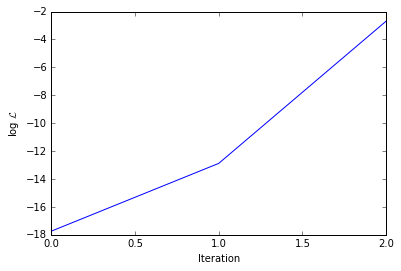

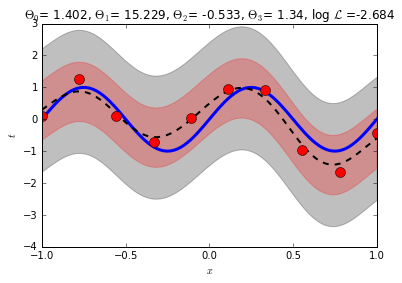

In [109]:
print 'Performing Newton Conjugate Gradient Ascent on Log-Likelihood\n'

theta = np.array([1,1,0,0.5])
theta_init = copy(theta)

print 'Initial Error: ' + str(-gp_loss(theta_init)) +'\n'

from scipy import optimize
res = optimize.fmin_ncg(gp_loss, theta_init, fprime=grad_loss, disp=False, retall=True)

thetaM = res[1]
niter = len(thetaM)
fn = []
for i in range(niter):
    fn.append(-gp_loss(thetaM[i]))

plot(range(niter), fn)
xlabel('Iteration')
ylabel('log $\mathcal{L}$')
show()

t_opt = res[0]

theta = np.array([np.exp(t_opt[0]), np.exp(t_opt[1]), t_opt[2], np.exp(t_opt[3])])

K = computeK(x_train, x_train, theta)
C = K + (1 / beta) * np.identity(N)
invC = inv(C)

mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C, invC)

for s in range(5):
    w = numpy.random.multivariate_normal(zeros(len(x_test)),diag(var_test[:,0]))
#    plt.plot(x_test,w)

gp_plot( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta )

log_like = -gp_loss( t_opt)
log_like = round(log_like,3)

xlabel('$x$')
ylabel('$t$')

title('$\Theta_0$= '+str(round(theta[0],3)) + ', $\Theta_1$= '+str(round(theta[1],3)) +
      ', $\Theta_2$= '+str(round(theta[2],3)) + ', $\Theta_3$= '+str(round(theta[3],3)) +
      ', log $\mathcal{L}$ =' + str(log_like))

show()